## Read Data (replies excluded)

In [1]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
import pandas as pd

text = pd.read_csv('Jan6(excludes replies).csv')
print('The number of tweets (excludes replies):',len(text))

The number of tweets (excludes replies): 6501


## Data Cleaning

In [2]:
import gensim
import gensim.corpora as corpora
import re
porter = PorterStemmer()
stop_words = stopwords.words('english')
#stop_words += ['cultured','clean','cultivated','meat']
stop_words += ['rt']
b = []
for i,u in text.iterrows():
    a = []
    word =''
    for words in str(u['tweets']).split():
        if '@' not in words: #remove @users
            words = words.replace('#','') #remove hashtag symbol
            if '#' not in words:
                if 'http' not in words: #remove URLs
                    if'&amp' not in words: #remove symbol
                        words = words.lower()# lower form
                        words = re.sub(r'[^a-zA-Z]', ' ', words) #replace non-alphabets characters with space. From "can't" to "can t"
                        if len(words)>2:
                            word += (words+' ')
    doc = ''
    for token in word.split():
        if len(token) >1:
            if token not in stop_words:
                token = porter.stem(token) #root form
                doc += (token+' ')
    b.append(doc)
text['processed']=[i for i in b]

# exclude tweets that are not in English
non_english_list = ['temiz','rkiy','erik','nda','konu','dan','da','ba','temiz','al','viand','para','na','dann','uft','laboratorio','dieser','kalbimi',
                   'restoranda','evento','mayo','komo','ind','tica','futuro','sonra','yla','cre','ili','daki',
                   'zaman']
index_axis = []
for index,i in text.iterrows():
    if len(i['processed']) == 0:
        index_axis.append(index)
    else:
        for word in i['processed'].split():
            if word in non_english_list:
                index_axis.append(index)
                break
text.drop(text.index[index_axis],inplace=True)
print("number of tweets after cleaning:",len(text))

number of tweets after cleaning: 6230


In [3]:
text

,Unnamed: 0,tweets,date,Company,url,processed
0,0,"RT: To start off last year, in January 2020, @...",2021-01-05 15:59:55,Memphis Meats,https://twitter.com/MemphisMeats/status/134648...,start last year januari becam first cellbasedm...
1,1,Happy New Year from Memphis Meats! We’re closi...,2020-12-30 23:14:26,Memphis Meats,https://twitter.com/MemphisMeats/status/134442...,happi new year memphi meat close gratitud team...
2,2,"In these unprecedented times, we are devoting ...",2020-12-23 19:00:56,Memphis Meats,https://twitter.com/MemphisMeats/status/134182...,unpreced time devot attent brighter futur cell...
3,4,We chatted with @FoodDive on what’s happening ...,2020-12-16 21:26:40,Memphis Meats,https://twitter.com/MemphisMeats/status/133932...,chat happen cellular agricultur
4,5,From climate chaos to climate transformation? ...,2020-12-15 20:16:03,Memphis Meats,https://twitter.com/MemphisMeats/status/133894...,climat chao climat transform proud name cleant...
...,...,...,...,...,...,...
6494,7934,We're a growing team on an enormously exciting...,2019-09-27 04:00:29,Vow,https://twitter.com/vowfood/status/11774327967...,grow team enorm excit mission join team make r...
6495,7936,"Next week in Melbourne, our CCO Tim will be sp...",2019-08-28 02:18:29,Vow,https://twitter.com/vowfood/status/11665354944...,next week melbourn cco tim speak futur altern ...
6496,7937,RT: Shout out to @vowfood - founders @peppsyd ...,2019-08-15 18:49:46,Vow,https://twitter.com/vowfood/status/11620739148...,shout founder featur last week plate dumpl mad...
6498,7939,I'm attending Cellular Agriculture: End of the...,2020-11-18 14:17:37,LabFarmFoods,https://twitter.com/LabFarmFoods/status/132906...,attend cellular agricultur end year summit thi...


## GuidedLDA

In [4]:
import guidedlda
import numpy as np
seed_topic_list = [['greenhous','emiss','better','planet','save','reduc',
                   'system','futur','land','ecolog','plastic','climatechang'], #0 Environmental Impact
                   ['plant','vegan','vegetarian','anim','altern','protein','plantbas'], #1 Vegetarian
                   ['without','slaughter','cruelti','welfar','kill','cow','human','farm','save'],#2 Animal Welfare
                   ['consumpt','popul','demand','secur','wast','grow','global','sustain','need',
                   'consum','eat','growth','feed'],#3 Food Security
                   ['antibiot','antimicrobi','resist','safeti','contamin','free','health','overus',
                   'diseas','use','metal','bacteria'],#4 Food Safety
                   ['regulatori','usda','fda','safe','joint','label'],#5 Regulations
                   ['public','health','pandem','covid','risk','coronaviru'],# 6 Public Health
                   ['industri','suppli','convent','regular','system','chain','game','changer','compani'],#7 Food Industry
                   ['market','consum','store','groceri','product','demand','grow','launch','scale','cost','soon','sell'], #8 Market
                   ['seafood','sea','ocean','fish','aquacultur','shrimp','salmon','wild','lobster','tuna','sushi','crustacean'],#9 Seafood
                   ['chicken','duck','poultri','egg','burger','steak','meatbal','beef','sausag',
                    'tast','tender','textur','juici','test','delici','culinari','favorit','tasti'],#10 Poultry and Meat
                   ['stem','muscl','divis','biolog','cellular','technolog','agricultur','creat','made','lab','cell','biotech','tech'],#11 Process
                   ['seri','fund','rais','invest','investor','dollar','pound','round','startup',
                   'opportun','first','seed','isra','acceler','announc','happi','thrill','excit','pleas','contribut','honor','proud','statement'], #12 Fundraising Announcement
                   ['thank','support','shoutout','help','shout','question','mention'], #13 Appreciation
                   ['confer','regist','live','symposium','stream','livestream','summit','co','founder','talk','speak','ceo','tomorrow'], #14 Conference and Summit
                   ['hire','join','team','bring','welcom','work','appli','research','specialist','student','career','posit'],#15 Hiring Information
                   ['congrat','congratul','list','award','winner','finalist','partner','prize'],#16 Congratulations
                   ['check','post','paper','interview','articl','blog','news','break','read',
                   'latest','watch','podcast','listen','episod','stori','coverag','campaign','video','singapor','discuss','vote','panel',
                    'chat','scientist','report','ceo','media','bbc','present','innov']]#17 Media

from sklearn.feature_extraction.text import CountVectorizer
model = guidedlda.GuidedLDA(n_topics=20,n_iter=1000,random_state=1,refresh=10,alpha=0.01,eta=0.01)
vectorizer = CountVectorizer(min_df =1 )
X = vectorizer.fit_transform(text['processed'])

vocab = vectorizer.get_feature_names()
word2id = dict((v,idx) for idx,v in enumerate(vocab))
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

model.fit(X.toarray(),seed_topics=seed_topics,seed_confidence=0.75)
topic_word = model.topic_word_
n_top_words = 30
vocab = tuple(vocab)

for i, topic_dist in enumerate(topic_word):
    print('\n')
    print('Topic:',i)
    words_probability = np.array(-topic_dist)
    for index in range(n_top_words):
        print(round(abs(np.sort(words_probability))[:(n_top_words)][index],4),'*',
              np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1][index],sep='',end='  ')

INFO:guidedlda:n_documents: 6230
INFO:guidedlda:vocab_size: 7511
INFO:guidedlda:n_words: 75115
INFO:guidedlda:n_topics: 20
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -986994
INFO:guidedlda:<10> log likelihood: -625032
INFO:guidedlda:<20> log likelihood: -610263
INFO:guidedlda:<30> log likelihood: -603792
INFO:guidedlda:<40> log likelihood: -600102
INFO:guidedlda:<50> log likelihood: -597151
INFO:guidedlda:<60> log likelihood: -595733
INFO:guidedlda:<70> log likelihood: -593757
INFO:guidedlda:<80> log likelihood: -592458
INFO:guidedlda:<90> log likelihood: -591694
INFO:guidedlda:<100> log likelihood: -591180
INFO:guidedlda:<110> log likelihood: -589628
INFO:guidedlda:<120> log likelihood: -589419
INFO:guidedlda:<130> log likelihood: -588675
INFO:guidedlda:<140> log likelihood: -588651
INFO:guidedlda:<150> log likelihood: -588051
INFO:guidedlda:<160> log likelihood: -587819
INFO:guidedlda:<170> log likelihood: -588224
INFO:guidedlda:<180> log likelihood: -587392
INFO:



Topic: 0
0.0413*food  0.0344*meat  0.0249*sustain  0.0241*futur  0.0144*make  0.0133*anim  0.0128*better  0.0128*chang  0.0126*culturedmeat  0.0121*agricultur  0.0103*clean  0.01*way  0.0097*world  0.0097*system  0.0095*support  0.0087*one  0.0085*technolog  0.0085*cleanmeat  0.0077*join  0.0074*healthier  0.0074*human  0.0067*question  0.0067*climat  0.0064*tast  0.0062*produc  0.0062*convers  0.0062*eat  0.0062*next  0.0059*product  0.0059*build  

Topic: 1
0.0521*meat  0.0329*base  0.0275*plant  0.0225*protein  0.0178*food  0.0164*market  0.0142*plantbas  0.014*altern  0.0136*industri  0.0124*year  0.011*burger  0.0098*vegan  0.0092*new  0.009*invest  0.0086*product  0.0084*beyond  0.0078*cell  0.0072*compani  0.0066*grow  0.0064*next  0.0064*demand  0.0064*futureoffood  0.0064*global  0.0062*foodtech  0.006*first  0.0058*produc  0.0058*dairi  0.0056*billion  0.0052*chang  0.0052*egg  

Topic: 2
0.0967*meat  0.0493*anim  0.0242*without  0.0197*make  0.0187*slaughter  0.0167*eat  0

## Categorize Tweets according to their most salient topic

In [5]:
#X = X.toarray()
doc_topic = model.transform(X)
topic_number = []
number = []

for i in range(len(doc_topic)):
    topic_number.append(doc_topic[i].argmax())
    number.append('1')
data = pd.DataFrame(data=[i for i in topic_number],columns=['topic_number'])
data['number'] = [i for i in number]
print(data.groupby('topic_number')['number'].count())
        
    

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


topic_number
0     314
1     383
2     527
3     357
4     197
5     239
6     217
7     232
8     259
9     213
10    268
11    356
12    396
13    469
14    519
15    269
16    324
17    435
18    107
19    149
Name: number, dtype: int64


In [10]:
doc_topic = model.transform(X)
topic_number1 = []


for i in range(len(doc_topic)):
    topic_number1.append(doc_topic[i].argmax())
text['topic number'] = [i for i in topic_number1]
topic_author = text.groupby(['topic number','Company'])['tweets'].count()
topic_author_3d = topic_author.unstack()
topic = ['Environmental Impact','Vegetarian and Alternative Protein','Animal Welfare',
        'Food Security', 'Food Safety', 'Regulations','Public Health','Food Industry',
         'Market','Seafood','Poultry and Meat','Process','Announcement(fundraising)',
        'Appreciation','Conference and Summit','Hiring Informaiton','Congratulations',
        'Media','Unseeded Topic 1','Unseeded Topic 2']
topic_author_3d

/opt/anaconda3/lib/python3.7/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):


Company,Aleph Farms,Avant Meats,Balletic Foods,BlueNalu,CUBIQ FOODS,Finless Foods,Future Fields,FutureMeat,LabFarmFoods,Meatable,Memphis Meats,Mission Barns,Mosa Meat,New Age Meats,SuperMeat,Vow,Wildtype,biftek.co 🔬👩‍🔬🐄🥗,shiokmeats
topic number,,,,,,,,,,,,,,,,,,,
0,22.0,NaN,NaN,8.0,5.0,22.0,2.0,4.0,NaN,6.0,117.0,NaN,5.0,21.0,37.0,3.0,2.0,53.0,7.0
1,24.0,NaN,1.0,8.0,36.0,14.0,NaN,4.0,NaN,2.0,46.0,NaN,2.0,7.0,6.0,1.0,2.0,215.0,15.0
2,29.0,NaN,1.0,6.0,3.0,29.0,NaN,3.0,NaN,12.0,225.0,NaN,2.0,15.0,107.0,NaN,1.0,84.0,10.0
3,27.0,NaN,1.0,37.0,16.0,50.0,2.0,1.0,1.0,7.0,97.0,NaN,5.0,3.0,17.0,NaN,11.0,66.0,16.0
4,6.0,NaN,NaN,3.0,8.0,26.0,NaN,NaN,NaN,2.0,27.0,NaN,3.0,3.0,6.0,NaN,3.0,90.0,20.0
5,13.0,NaN,2.0,7.0,4.0,20.0,2.0,1.0,NaN,23.0,53.0,NaN,2.0,37.0,19.0,1.0,3.0,46.0,6.0
6,22.0,NaN,NaN,4.0,8.0,20.0,2.0,NaN,NaN,2.0,34.0,NaN,2.0,4.0,9.0,3.0,1.0,100.0,6.0
7,40.0,NaN,1.0,18.0,10.0,24.0,3.0,1.0,NaN,3.0,43.0,NaN,3.0,7.0,6.0,NaN,4.0,57.0,12.0
8,33.0,1.0,NaN,23.0,9.0,14.0,5.0,NaN,NaN,1.0,25.0,1.0,11.0,12.0,1.0,1.0,3.0,101.0,18.0


In [7]:
#col_name = topic_author_3d.columns.tolist()
#col_name.insert(0,'Topic')
#topic_author_3d.reindex(columns=col_name)
#topic_author_3d['Topic'] = [i for i in topic]
#topic_author_3d.insert(loc=0,column='Topic',value=topic)
#topic_author_3d.to_csv('topic_author_3d.csv')

## Topic-Author Distribution Heatmap

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 129367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 128300 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 128105 missing fr

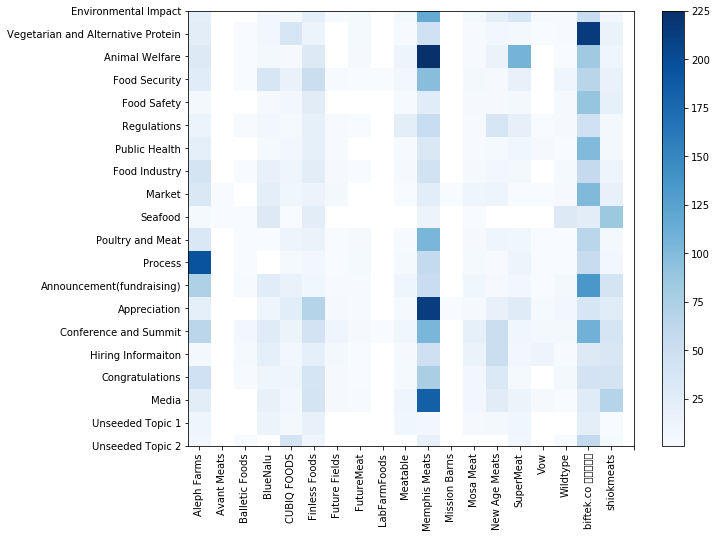

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(topic_author_3d,cmap="Blues")
plt.colorbar()
plt.xticks(range(len(topic_author_3d)), topic_author_3d.columns,rotation=90)
plt.yticks(range(len(topic_author_3d)), topic)
plt.show()